## Project: Borrower's Credit Prediction (Simple, Intuitive, Insightful Model)
#### à¹€à¸›à¹‰à¸²à¸«à¸¡à¸²à¸¢: à¸ªà¸£à¹‰à¸²à¸‡à¹‚à¸¡à¹€à¸”à¸¥à¸ªà¸–à¸´à¸•à¸´à¸—à¸µà¹ˆ Simple à¹€à¸žà¸·à¹ˆà¸­à¸ˆà¸°à¸«à¸² Insights à¸§à¹ˆà¸²à¸›à¸±à¸ˆà¸ˆà¸±à¸¢à¹ƒà¸”à¸—à¸µà¹ˆà¸—à¸³à¹ƒà¸«à¹‰à¸šà¸¸à¸„à¸„à¸¥à¸™à¸±à¹‰à¸™à¹„à¸”à¹‰ GOOD/BAD CREDIT
##### (à¹„à¸¡à¹ˆà¹€à¸­à¸² Black-Box Model)

## Import & Style

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.special import expit  # For logistic function in scorecard
import warnings

warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

In [2]:
# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('pastel')

## Load Data

In [3]:
train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv') # Test data is loaded but not used in this version for brevity, focus is on insights from train_data

In [4]:
# Display basic information about the training data
print("\nFirst 5 rows of training data:")
print(train_data.head())
print(f"\nShape of training data: {train_data.shape}")
print("\nData types and missing values in training data:")
train_data.info()


First 5 rows of training data:
   Id  laufkont  laufzeit  moral  verw  hoehe  sparkont  beszeit  rate  \
0   0         1        18      4     2   1049         1        2     4   
1   1         1         9      4     0   2799         1        3     2   
2   2         2        12      2     9    841         2        4     2   
3   3         1        12      4     0   2122         1        3     3   
4   5         1        10      4     0   2241         1        2     1   

   famges  ...  verm  alter  weitkred  wohn  bishkred  beruf  pers  telef  \
0       2  ...     2     21         3     1         1      3     2      1   
1       3  ...     1     36         3     1         2      3     1      1   
2       2  ...     1     23         3     1         1      2     2      1   
3       3  ...     1     39         3     1         2      2     1      1   
4       3  ...     1     48         3     1         2      2     1      1   

   gastarb  kredit  
0        2       1  
1        2       1

## Exploratory Data Analysis (EDA)

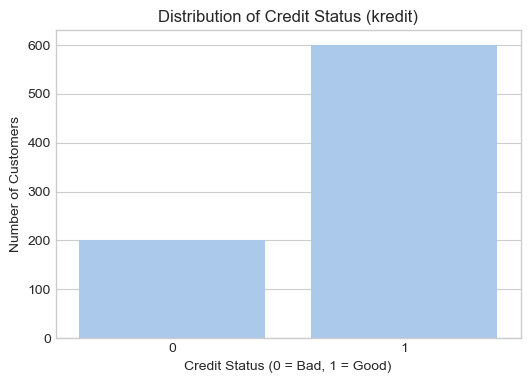

In [5]:
# Target variable distribution ('kredit')
# Assuming 0 = Bad Credit, 1 = Good Credit
plt.figure(figsize=(6, 4))
sns.countplot(data=train_data, x='kredit')
plt.title("Distribution of Credit Status (kredit)")
plt.xlabel("Credit Status (0 = Bad, 1 = Good)")
plt.ylabel("Number of Customers")
plt.show()

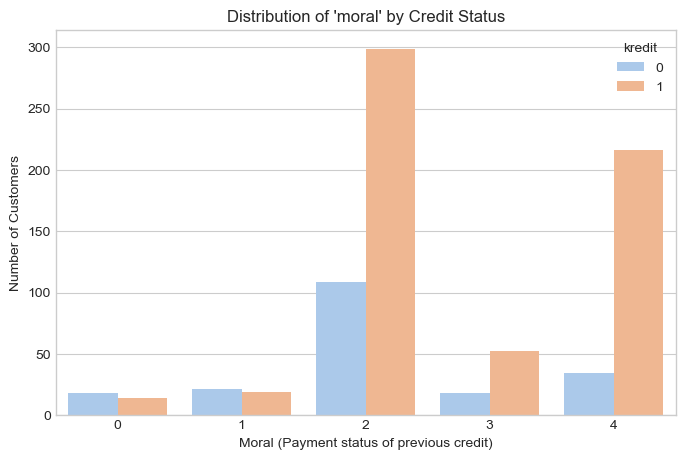

In [6]:
# Example: Distribution of 'moral' (Payment status of previous credit)
# This was a feature plotted in the original notebook.
# The meaning of 'moral' values (e.g., 1, 2, 3, 4) should be understood from data documentation.
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='moral', hue='kredit')
plt.title("Distribution of 'moral' by Credit Status")
plt.xlabel("Moral (Payment status of previous credit)")
plt.ylabel("Number of Customers")
plt.show()

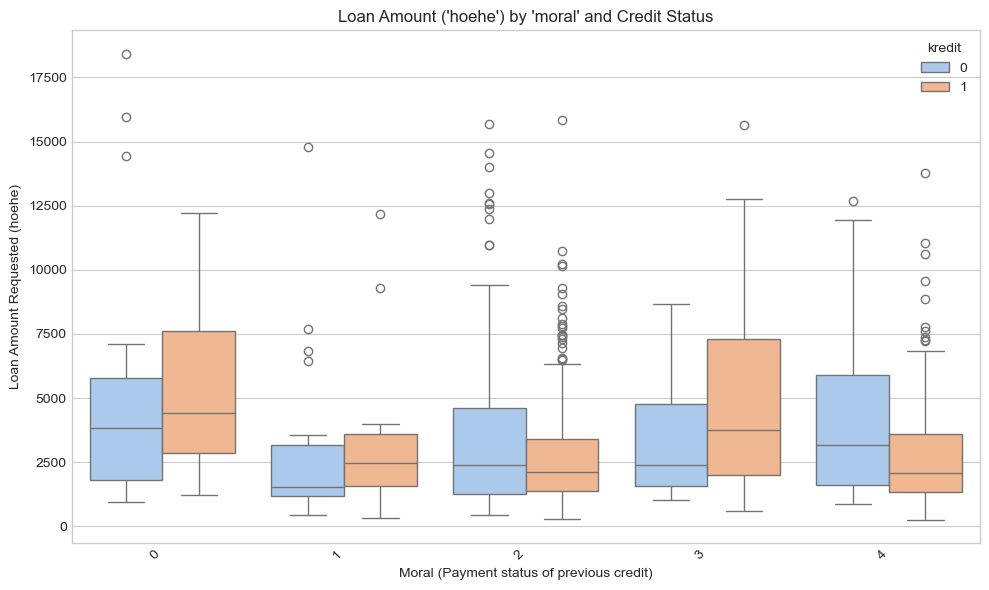

In [7]:
# Example: Loan amount ('hoehe') vs. 'moral'
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='moral', y='hoehe', hue='kredit')
plt.title("Loan Amount ('hoehe') by 'moral' and Credit Status")
plt.xlabel("Moral (Payment status of previous credit)")
plt.ylabel("Loan Amount Requested (hoehe)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

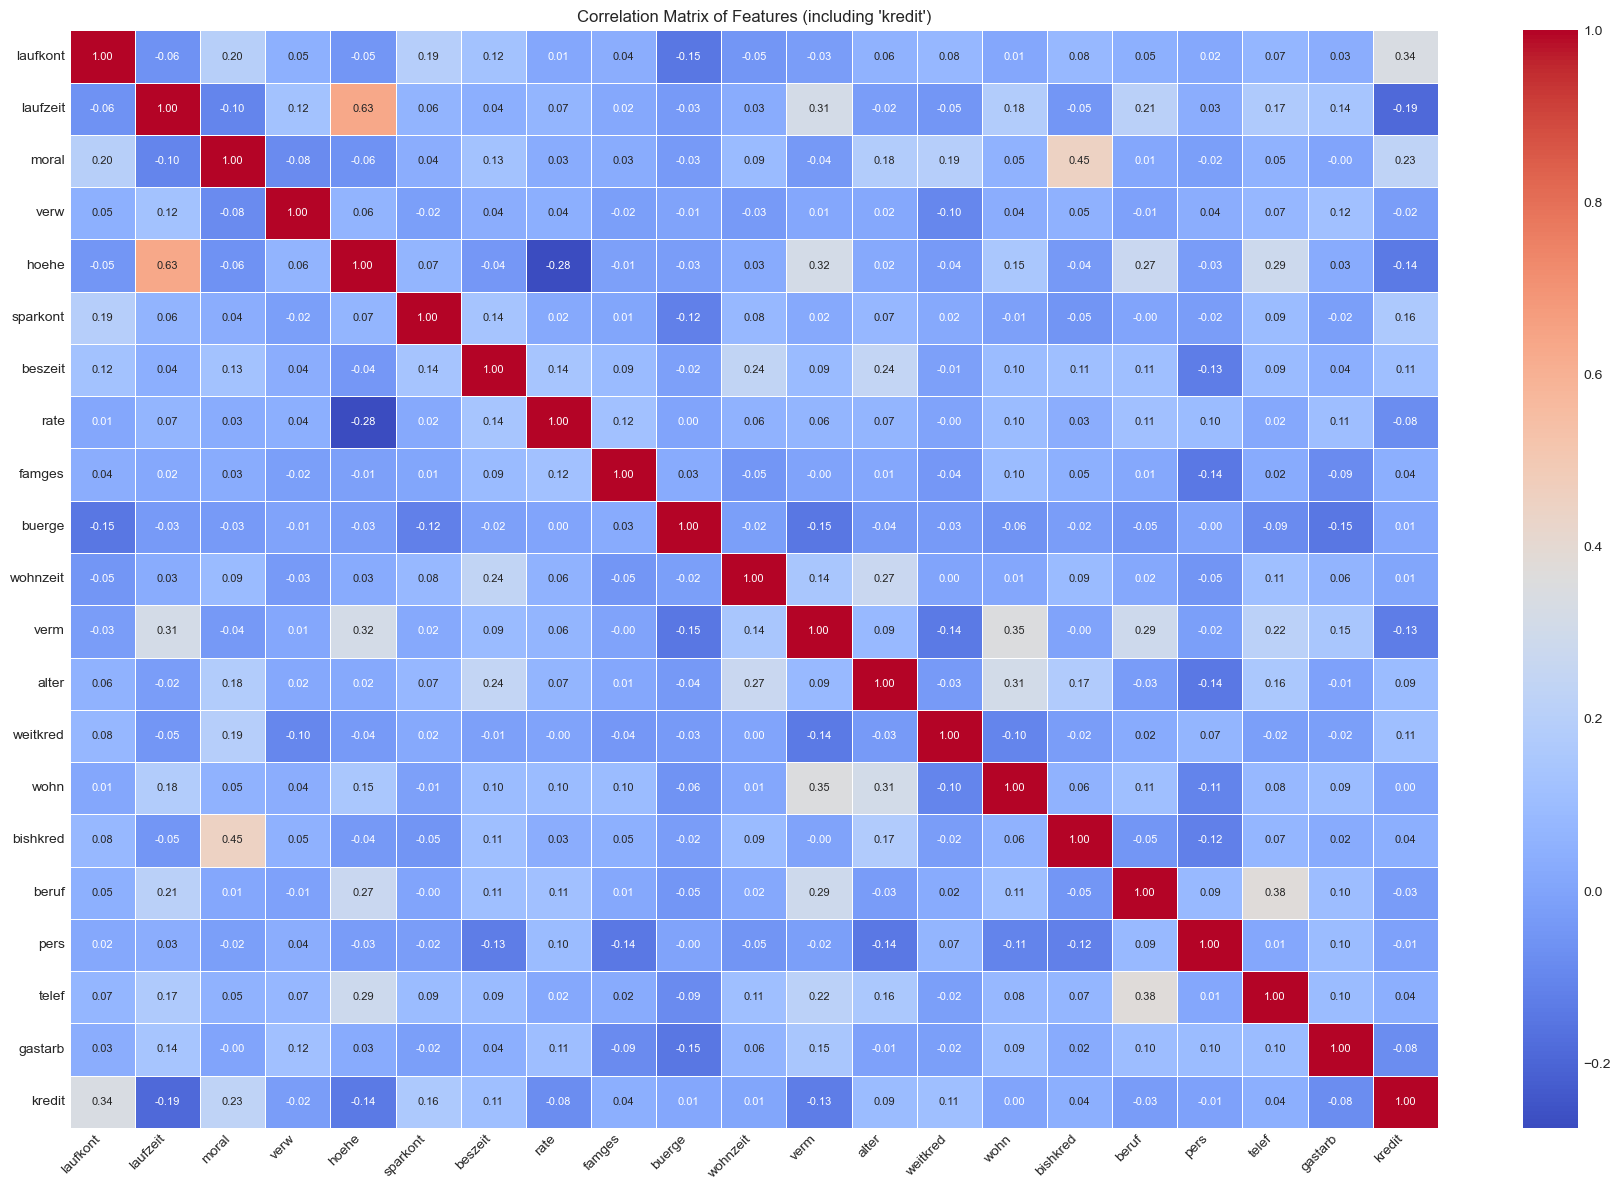

In [8]:
# Correlation Heatmap of numeric features and the target variable
# Drop 'Id' for correlation analysis
plt.figure(figsize=(18, 12))
# Select only numeric columns for correlation, or handle non-numeric appropriately
numeric_cols = train_data.select_dtypes(include=np.number).columns.tolist()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
correlation_matrix = train_data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title("Correlation Matrix of Features (including 'kredit')")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Preprocessing

In [9]:
# Separate features (X) and target (y)
# 'kredit' is the target variable (0=Bad Credit, 1=Good Credit)
X = train_data.drop(['Id', 'kredit'], axis=1)
y = train_data['kredit']
feature_names = X.columns

In [10]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify for balanced classes in splits
)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (640, 20)
Validation data shape: (160, 20)


In [11]:
# Scale numerical features (important for Logistic Regression)
# Note: Decision Trees do not strictly require feature scaling,
# but we will use unscaled data for DT for easier rule interpretation.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [12]:
# For creating DataFrames later with scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_names)

## Models

In [13]:
# Model 1: Logistic Regression (Simple & Interpretable Coefficients)
# Logistic Regression is simple, effective for binary classification,
# and its coefficients provide insights into feature importance and direction.

In [14]:
log_reg = LogisticRegression(C=1.0, random_state=42, max_iter=1000, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [15]:
# Predictions
y_pred_lr = log_reg.predict(X_val_scaled)
y_prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1] # Probability of being Good Credit

In [16]:
# Evaluation
print(f"Accuracy (Logistic Regression): {accuracy_score(y_val, y_pred_lr):.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_val, y_pred_lr, target_names=['Bad Credit (0)', 'Good Credit (1)']))

Accuracy (Logistic Regression): 0.7250

Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

 Bad Credit (0)       0.44      0.40      0.42        40
Good Credit (1)       0.81      0.83      0.82       120

       accuracy                           0.72       160
      macro avg       0.63      0.62      0.62       160
   weighted avg       0.72      0.72      0.72       160




Top 10 Features by Absolute Coefficient (Logistic Regression):
     Feature  Coefficient
0   laufkont     0.814368
2      moral     0.458982
7       rate    -0.308903
5   sparkont     0.288501
19   gastarb    -0.268025
11      verm    -0.252846
1   laufzeit    -0.241278
4      hoehe    -0.222254
14      wohn     0.189028
13  weitkred     0.186169


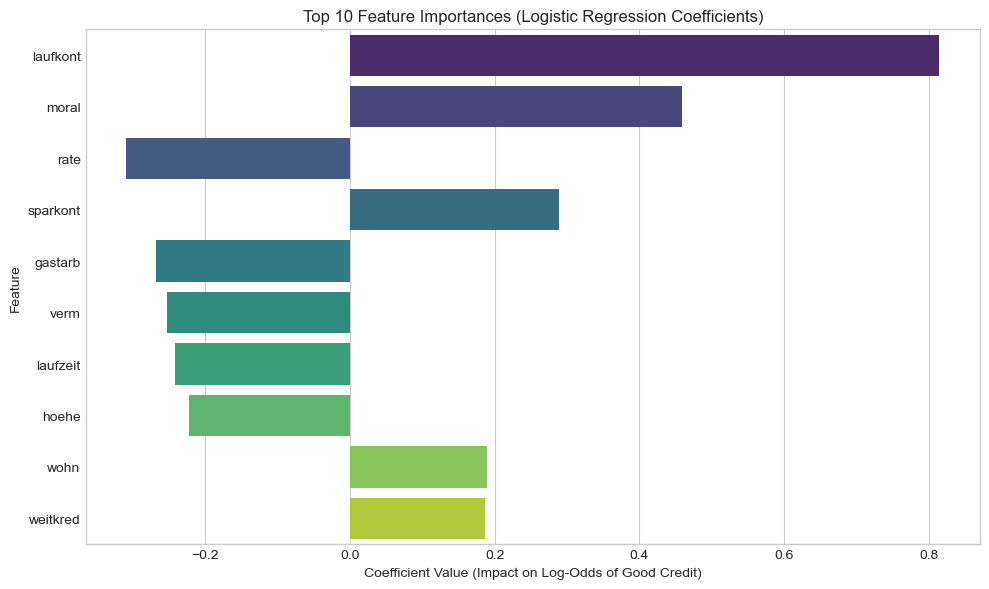


Interpreting Coefficients:
 - Positive coefficient: Increases the log-odds of being 'Good Credit'.
 - Negative coefficient: Decreases the log-odds of being 'Good Credit'.
 - Larger absolute value: Stronger impact on the outcome.

Examples of interpretation:
 - Factors positively associated with Good Credit: laufkont, moral, sparkont
 - Factors negatively associated with Good Credit (positively with Bad Credit): rate, gastarb, verm


In [17]:
# Feature Importance (Coefficients)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg.coef_[0],
    'Absolute_Coefficient': np.abs(log_reg.coef_[0])
}).sort_values(by='Absolute_Coefficient', ascending=False)

print("\nTop 10 Features by Absolute Coefficient (Logistic Regression):")
print(coef_df[['Feature', 'Coefficient']].head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value (Impact on Log-Odds of Good Credit)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nInterpreting Coefficients:")
print(" - Positive coefficient: Increases the log-odds of being 'Good Credit'.")
print(" - Negative coefficient: Decreases the log-odds of being 'Good Credit'.")
print(" - Larger absolute value: Stronger impact on the outcome.")

top_pos_lr = coef_df[coef_df['Coefficient'] > 0].head(3)['Feature'].tolist()
top_neg_lr = coef_df[coef_df['Coefficient'] < 0].head(3)['Feature'].tolist()
print(f"\nExamples of interpretation:")
print(f" - Factors positively associated with Good Credit: {', '.join(top_pos_lr)}")
print(f" - Factors negatively associated with Good Credit (positively with Bad Credit): {', '.join(top_neg_lr)}")

In [18]:
# Model 2: Decision Tree (Intuitive, Rule-Based)
# Decision Trees are highly interpretable, showing decision paths.
# We use a shallow tree (max_depth=4) for easier visualization and understanding.
# Using unscaled data (X_train, X_val) for intuitive threshold values.

In [19]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=42, class_weight='balanced')
dt.fit(X_train, y_train) # Use unscaled data for interpretability of rules

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=20, random_state=42)

In [20]:
# Predictions
y_pred_dt = dt.predict(X_val)
y_prob_dt = dt.predict_proba(X_val)[:, 1] # Probability of being Good Credit

In [21]:
# Evaluation
print(f"Accuracy (Decision Tree): {accuracy_score(y_val, y_pred_dt):.4f}")
print("\nClassification Report (Decision Tree):")
print(classification_report(y_val, y_pred_dt, target_names=['Bad Credit (0)', 'Good Credit (1)']))

Accuracy (Decision Tree): 0.6750

Classification Report (Decision Tree):
                 precision    recall  f1-score   support

 Bad Credit (0)       0.40      0.62      0.49        40
Good Credit (1)       0.85      0.69      0.76       120

       accuracy                           0.68       160
      macro avg       0.63      0.66      0.63       160
   weighted avg       0.74      0.68      0.69       160




Top 10 Features by Importance (Decision Tree):
     Feature  Importance
0   laufkont    0.490554
1   laufzeit    0.116489
4      hoehe    0.074197
11      verm    0.070951
12     alter    0.063116
5   sparkont    0.047486
3       verw    0.044617
6    beszeit    0.044300
2      moral    0.024543
13  weitkred    0.023748


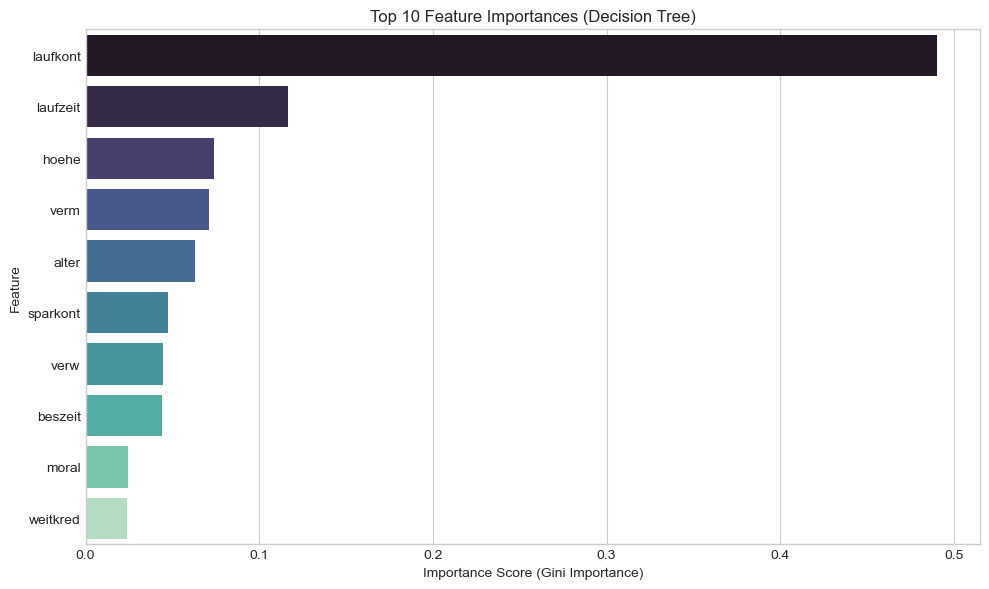

In [22]:
# Feature Importance
feat_imp_dt_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Features by Importance (Decision Tree):")
print(feat_imp_dt_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_dt_df.head(10), palette='mako')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance Score (Gini Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Visualizing the Decision Tree (first few levels):


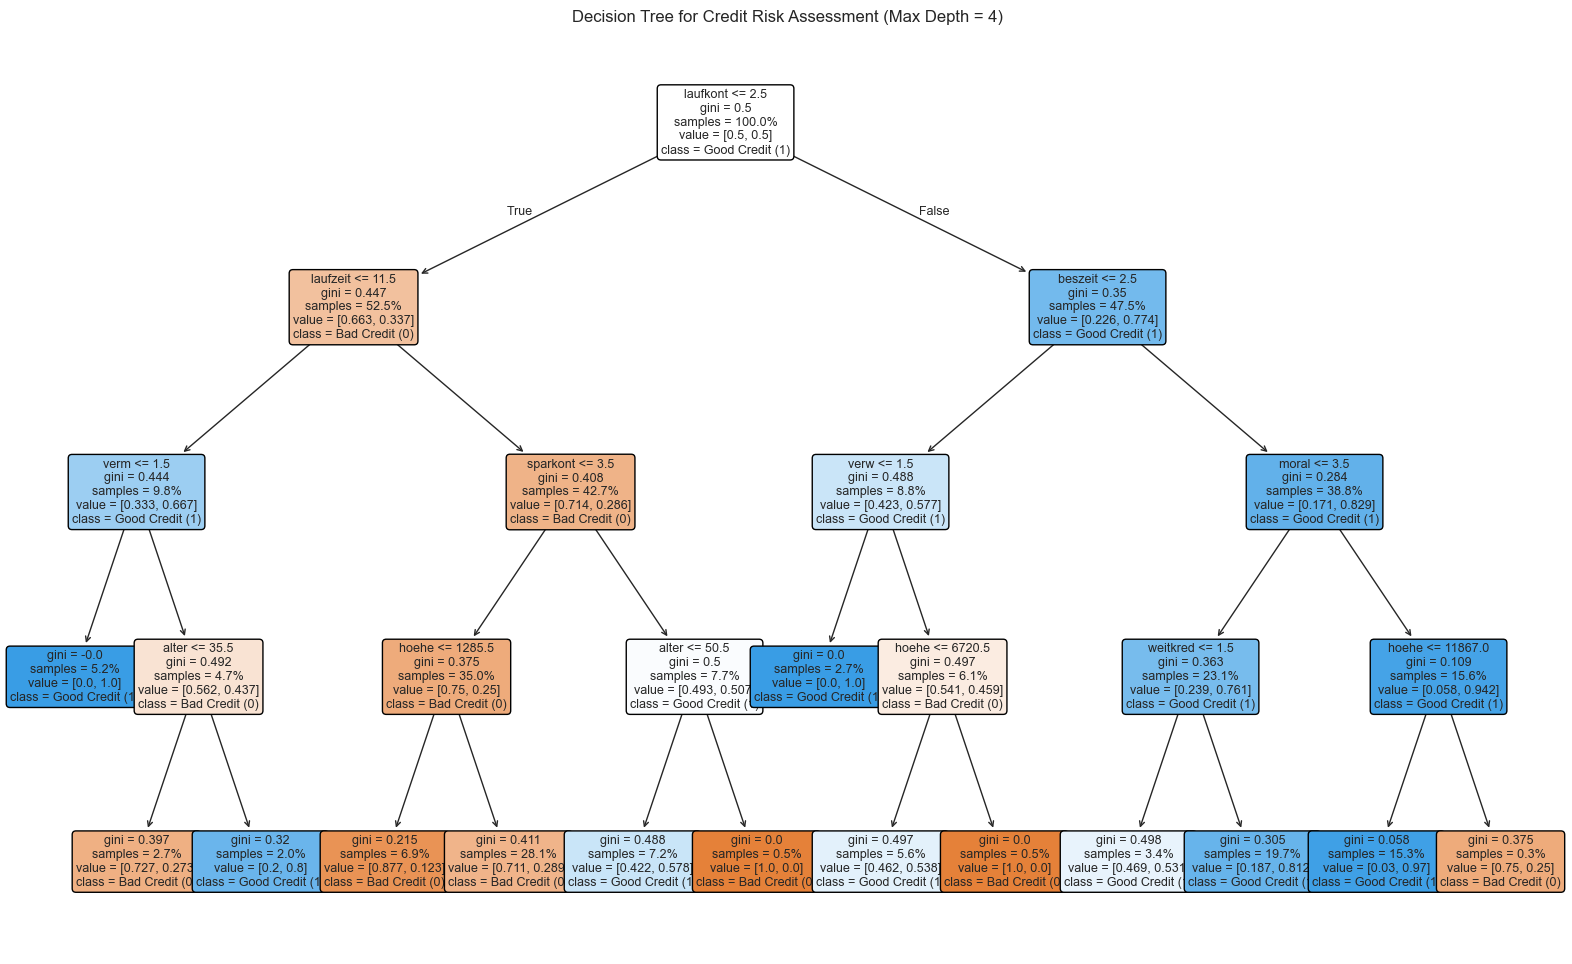


Interpreting Decision Tree Rules:
 - Each node represents a decision based on a feature's threshold.
 - Follow paths from the root to leaf nodes to understand specific customer segments.
 - 'gini' measures impurity; lower gini means a purer node (more samples of one class).
 - 'value' shows the distribution of samples for [Bad Credit, Good Credit].
 - 'class' indicates the majority class in that node.

Example of how one might articulate rules from a tree (illustrative):

    # Rule Derivation Example (based on a hypothetical simple tree branch):
    # 1. First question: What is the status of the checking account ('laufkont')?
    #    If 'laufkont' <= 1.5 (e.g., no checking or small amount) -> Indicates better account status by this split.
    #    If 'laufkont' > 1.5 (e.g., medium/rich or no account and bad history) -> Indicates potentially less stable.
    #
    # ðŸŸ¢ Branch 1: Customers with good checking account status ('laufkont' <= 1.5)
    #    Next question: What is the loan

In [23]:
# Plot the Decision Tree
print("\nVisualizing the Decision Tree (first few levels):")
plt.figure(figsize=(20, 12)) # Increased figure size
plot_tree(dt,
          feature_names=X.columns,
          class_names=['Bad Credit (0)', 'Good Credit (1)'], # Use meaningful names
          filled=True,
          rounded=True,
          proportion=True, # Show proportions instead of counts
          fontsize=9) # Adjust fontsize
plt.title("Decision Tree for Credit Risk Assessment (Max Depth = 4)")
plt.show()

print("\nInterpreting Decision Tree Rules:")
print(" - Each node represents a decision based on a feature's threshold.")
print(" - Follow paths from the root to leaf nodes to understand specific customer segments.")
print(" - 'gini' measures impurity; lower gini means a purer node (more samples of one class).")
print(" - 'value' shows the distribution of samples for [Bad Credit, Good Credit].")
print(" - 'class' indicates the majority class in that node.")

# The following is a manual interpretation based on a hypothetical tree structure,
# similar to the original notebook. The actual rules should be derived from the plotted tree above.
print("\nExample of how one might articulate rules from a tree (illustrative):")
print("""
    # Rule Derivation Example (based on a hypothetical simple tree branch):
    # 1. First question: What is the status of the checking account ('laufkont')?
    #    If 'laufkont' <= 1.5 (e.g., no checking or small amount) -> Indicates better account status by this split.
    #    If 'laufkont' > 1.5 (e.g., medium/rich or no account and bad history) -> Indicates potentially less stable.
    #
    # ðŸŸ¢ Branch 1: Customers with good checking account status ('laufkont' <= 1.5)
    #    Next question: What is the loan amount ('hoehe')?
    #    If 'hoehe' <= 2500 (e.g., requesting a small loan amount)
    #    âœ… Model predicts 'Good Credit'.
    #
    #    If 'hoehe' > 2500 (e.g., requesting a large loan amount)
    #    Next question: What is the customer's age ('alter')?
    #    If 'alter' <= 28 (e.g., younger customer)
    #    ðŸ”´ Model predicts 'Bad Credit'.
    #
    #    If 'alter' > 28 (e.g., older customer)
    #    ðŸŸ¡ Model predicts 'Good Credit' (but perhaps with less confidence or more mixed).
    #
    # ðŸ“Œ Interpretation: Good checking account + small loan amount -> Likely good credit.
    #    Good checking account + large loan amount + young age -> Riskier.
    #
    # ðŸ”´ Branch 2: Customers with poorer checking account status ('laufkont' > 1.5)
    #    Next question: What is the installment rate percentage ('rate')?
    #    If 'rate' <= 2.5 (e.g., installment is a small percentage of income)
    #    âœ… Model predicts 'Good Credit'.
    #
    #    If 'rate' > 2.5 (e.g., installment is a large percentage of income)
    #    ðŸ”´ Model predicts 'Bad Credit'.
    #
    # ðŸ“Œ Interpretation: Poor checking account + high installment rate -> High risk.
    """)


In [24]:
# Model 3: Scorecard Model (Practical Application derived from Logistic Regression)
# A scorecard translates statistical model outputs into a point-based system,
# commonly used in credit scoring for its simplicity and ease of use.
# This scorecard is derived from the Logistic Regression model.

In [25]:
# Parameters for scorecard scaling
# Target: A certain score (e.g., 600) corresponds to a certain odds ratio (e.g., 50:1 Good:Bad)
# Points to Double Odds (PDO): e.g., 20 points means odds double for every 20 point increase.
# Let's use a simpler approach as in the original notebook: a direct scaling of log-odds.
# The original notebook used scaling_factor and base_score directly from coefficients.

# Coefficients are from the model trained on SCALED data.
# The score calculation should use SCALED feature values.

base_log_odds = log_reg.intercept_[0]
# A common practice for a scorecard base score:
# Offset = TargetScore - (Factor * log(TargetOdds))
# Factor = PDO / log(2)
# For simplicity, we'll use the scaled intercept as base contribution to log_odds.

# Define scaling parameters (can be adjusted based on desired score range)
# Let's define a desired base score (e.g., 400) and points for specific log-odds.
# For this example, we'll keep the original notebook's direct scaling approach,
# but ensure consistency with scaled features.

# Scaling factor: determines how much scores change with log_odds.
# Larger factor = wider range of scores.
points_factor = 20 / np.log(2)  # Points to Double the Odds (PDO = 20)
offset = 600 - (points_factor * base_log_odds) # Example: Target score 600 at base_log_odds

# Simplified approach from original notebook for direct score mapping:
# Use a linear transformation of log-odds: Score = A * log_odds + B
# Let log_odds_good = base_log_odds + sum(coef_i * scaled_x_i)
# Score = points_factor * log_odds_good + offset
# This aligns probability with score.

# Calculate scores for each feature's coefficient
# score_points_per_unit_scaled_feature = coefficient * points_factor
feature_points = {
    feature: log_reg.coef_[0][i] * points_factor
    for i, feature in enumerate(feature_names)
}

In [26]:
# Function to calculate customer's total score using SCALED data
def calculate_customer_score_scaled(scaled_customer_data_dict, base_log_odds, feature_points, points_factor, offset):
    """
    Calculates credit score for a customer using their SCALED feature values.
    scaled_customer_data_dict: A dictionary of {feature_name: scaled_value}.
    """
    customer_log_odds = base_log_odds
    for feature, scaled_value in scaled_customer_data_dict.items():
        if feature in feature_points:
            customer_log_odds += log_reg.coef_[0][feature_names.tolist().index(feature)] * scaled_value

    score = customer_log_odds * points_factor + offset
    return score

In [27]:
# Display base score (offset) and points for top features
print(f"Scorecard Offset (Base Score if all scaled features are 0): {offset:.2f}")
print("\nPoints for each feature (per unit change in SCALED feature value):")
sorted_feature_points = sorted(feature_points.items(), key=lambda item: abs(item[1]), reverse=True)
for feature, points in sorted_feature_points[:10]:
    print(f"  - {feature}: {points:.2f} points")

Scorecard Offset (Base Score if all scaled features are 0): 557.58

Points for each feature (per unit change in SCALED feature value):
  - laufkont: 23.50 points
  - moral: 13.24 points
  - rate: -8.91 points
  - sparkont: 8.32 points
  - gastarb: -7.73 points
  - verm: -7.30 points
  - laufzeit: -6.96 points
  - hoehe: -6.41 points
  - wohn: 5.45 points
  - weitkred: 5.37 points


In [28]:
# Calculate scores for the validation set (using SCALED data)
X_val_scores = []
for index, row in X_val_scaled_df.iterrows(): # Iterate over scaled validation data
    scaled_customer_dict = row.to_dict()
    score = calculate_customer_score_scaled(scaled_customer_dict, base_log_odds, feature_points, points_factor, offset)
    X_val_scores.append(score)

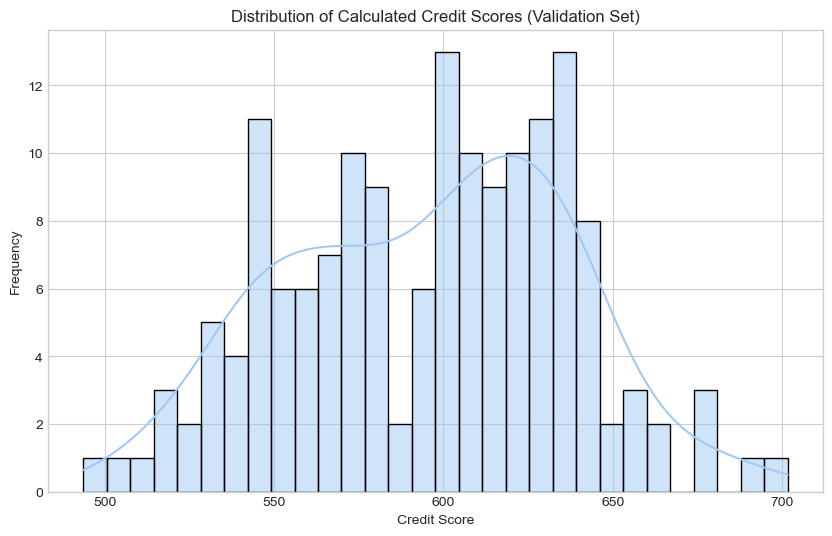

In [29]:
# Distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(X_val_scores, kde=True, bins=30)
plt.title('Distribution of Calculated Credit Scores (Validation Set)')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

In [30]:
# Convert scores to probabilities (for verification, should align with log_reg probabilities)
# Probability = expit(log_odds) = expit((Score - Offset) / Factor)
X_val_probs_from_score = expit((np.array(X_val_scores) - offset) / points_factor)

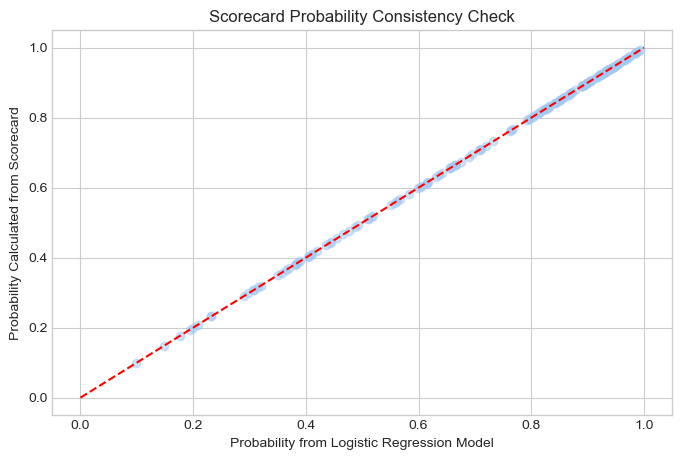


Example Score-based Decisioning (illustrative thresholds):
 - If customer_score > 650: Likely 'Good Credit' -> Approve.
 - If 550 < customer_score <= 650: Borderline -> Further review may be needed.
 - If customer_score <= 550: Likely 'Bad Credit' -> Decline or stricter conditions.


In [31]:
# Compare with y_prob_lr
plt.figure(figsize=(8, 5))
plt.scatter(y_prob_lr, X_val_probs_from_score, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--') # Identity line
plt.xlabel('Probability from Logistic Regression Model')
plt.ylabel('Probability Calculated from Scorecard')
plt.title('Scorecard Probability Consistency Check')
plt.show()
# Small differences can occur due to floating point arithmetic or if the score formula isn't a perfect reverse of LR.

print("\nExample Score-based Decisioning (illustrative thresholds):")
print(" - If customer_score > 650: Likely 'Good Credit' -> Approve.")
print(" - If 550 < customer_score <= 650: Borderline -> Further review may be needed.")
print(" - If customer_score <= 550: Likely 'Bad Credit' -> Decline or stricter conditions.")

In [32]:
# Model Comparison and Summary

In [33]:
print("\nâ–¶ Model Comparison and Summary")
print("""
1. Logistic Regression:
   - Pros: Simple, provides clear coefficients for feature importance and direction of impact (on log-odds). Good baseline.
   - Cons: Assumes linear relationship between features and log-odds. Requires scaled features for best coefficient interpretation if scales differ.
   - Best for: Understanding individual feature impacts quantitatively.

2. Decision Tree:
   - Pros: Highly interpretable through visual tree structure and rules. Handles non-linear relationships. No need for feature scaling for basic interpretation.
   - Cons: Can be prone to overfitting if not pruned (e.g., by limiting max_depth). Small changes in data can significantly change the tree structure.
   - Best for: Explaining decision processes to non-technical audiences, identifying key decision points.

3. Scorecard Model (derived from Logistic Regression):
   - Pros: Translates model output into a single, actionable score. Widely used and understood in industry.
   - Cons: Simplicity might hide complex interactions if not carefully designed. Score interpretation depends on scaling method.
   - Best for: Operationalizing credit decisions, providing a ranked assessment of creditworthiness.

Recommendations for Use:
- Use Logistic Regression to gain a foundational understanding of influential factors.
- Use Decision Trees (or their rules) to communicate decision logic clearly.
- Implement a Scorecard for practical, day-to-day credit assessment.
""")


â–¶ Model Comparison and Summary

1. Logistic Regression:
   - Pros: Simple, provides clear coefficients for feature importance and direction of impact (on log-odds). Good baseline.
   - Cons: Assumes linear relationship between features and log-odds. Requires scaled features for best coefficient interpretation if scales differ.
   - Best for: Understanding individual feature impacts quantitatively.

2. Decision Tree:
   - Pros: Highly interpretable through visual tree structure and rules. Handles non-linear relationships. No need for feature scaling for basic interpretation.
   - Cons: Can be prone to overfitting if not pruned (e.g., by limiting max_depth). Small changes in data can significantly change the tree structure.
   - Best for: Explaining decision processes to non-technical audiences, identifying key decision points.

3. Scorecard Model (derived from Logistic Regression):
   - Pros: Translates model output into a single, actionable score. Widely used and understood in indus

## Example Use Case : Predicting a New Customer

In [34]:
# Take a sample customer from the original X_val (unscaled)
sample_customer_unscaled_dict = X_val.iloc[0].to_dict()
print("\nSample Unscaled Customer Data:")
print(sample_customer_unscaled_dict)


Sample Unscaled Customer Data:
{'laufkont': 2, 'laufzeit': 36, 'moral': 4, 'verw': 1, 'hoehe': 5800, 'sparkont': 1, 'beszeit': 3, 'rate': 3, 'famges': 3, 'buerge': 1, 'wohnzeit': 4, 'verm': 3, 'alter': 34, 'weitkred': 3, 'wohn': 2, 'bishkred': 2, 'beruf': 3, 'pers': 2, 'telef': 2, 'gastarb': 2}


In [35]:
# Function to predict for a new customer
def predict_new_customer(unscaled_customer_data_dict, scaler_obj, lr_model, dt_model,
                         base_log_odds_sc, feature_points_sc, points_factor_sc, offset_sc):
    """
    Predicts creditworthiness for a new customer using all models.
    unscaled_customer_data_dict: dict of raw feature values.
    """
    customer_df_unscaled = pd.DataFrame([unscaled_customer_data_dict])

    # Ensure columns are in the same order as training data
    customer_df_unscaled = customer_df_unscaled[feature_names]


    # 1. Logistic Regression Prediction
    customer_df_scaled = scaler_obj.transform(customer_df_unscaled)
    prob_lr_new = lr_model.predict_proba(customer_df_scaled)[0, 1] # Prob of Good Credit
    pred_lr_new = lr_model.predict(customer_df_scaled)[0]

    # 2. Decision Tree Prediction
    prob_dt_new = dt_model.predict_proba(customer_df_unscaled)[0, 1] # Prob of Good Credit
    pred_dt_new = dt_model.predict(customer_df_unscaled)[0]

    # 3. Scorecard Calculation
    scaled_customer_dict_for_scorecard = pd.DataFrame(customer_df_scaled, columns=feature_names).iloc[0].to_dict()
    score_new = calculate_customer_score_scaled(
        scaled_customer_dict_for_scorecard,
        base_log_odds_sc, feature_points_sc, points_factor_sc, offset_sc
    )
    prob_score_new = expit((score_new - offset_sc) / points_factor_sc)

    # Recommendation based on illustrative score thresholds
    if score_new > 650:
        recommendation = "Approve (High Score)"
    elif score_new > 550:
        recommendation = "Further Review (Borderline Score)"
    else:
        recommendation = "Decline (Low Score)"

    return {
        'logistic_regression_prediction': 'Good Credit' if pred_lr_new == 1 else 'Bad Credit',
        'logistic_regression_probability_good_credit': f"{prob_lr_new:.4f}",
        'decision_tree_prediction': 'Good Credit' if pred_dt_new == 1 else 'Bad Credit',
        'decision_tree_probability_good_credit': f"{prob_dt_new:.4f}",
        'scorecard_score': f"{score_new:.2f}",
        'scorecard_probability_good_credit': f"{prob_score_new:.4f}",
        'final_recommendation_based_on_score': recommendation
    }

In [36]:
# Predict for the sample customer
new_prediction = predict_new_customer(
    sample_customer_unscaled_dict, scaler, log_reg, dt,
    base_log_odds, feature_points, points_factor, offset
)

In [37]:
print("\nPrediction for the Sample Customer:")
for key, value in new_prediction.items():
    print(f"  - {key}: {value}")


Prediction for the Sample Customer:
  - logistic_regression_prediction: Good Credit
  - logistic_regression_probability_good_credit: 0.6578
  - decision_tree_prediction: Bad Credit
  - decision_tree_probability_good_credit: 0.2895
  - scorecard_score: 576.43
  - scorecard_probability_good_credit: 0.6578
  - final_recommendation_based_on_score: Further Review (Borderline Score)


In [38]:
print("\n\nAnalysis complete! Models are ready for interpretation and potential deployment.")



Analysis complete! Models are ready for interpretation and potential deployment.
